# Cotton Imaging Mask R-CNN Model

In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch.cuda.empty_cache()

torch:  1.9 ; cuda:  cu111


In [2]:
# Some basic setup:
# Setup detectron2 logger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]

# import some common libraries
import numpy as np
import os, json, cv2, random

import fiftyone as fo
from PIL import Image

In [3]:
import logging

from detectron2.model_zoo import get_config
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detectron2.config import LazyCall as L
from detectron2.engine import (
    AMPTrainer,
    SimpleTrainer,
    default_argument_parser,
    default_setup,
    default_writers,
    hooks,
    launch,
)
from detectron2.engine.defaults import create_ddp_model
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
import detectron2

logger = logging.getLogger("detectron2")

In [4]:
def do_test(cfg, model):
    if "evaluator" in cfg.dataloader:
        ret = inference_on_dataset(
            model, instantiate(cfg.dataloader.test), instantiate(cfg.dataloader.evaluator)
        )
        print_csv_format(ret)
        return ret

In [5]:
def do_train(cfg):
    model = instantiate(cfg.model)
    logger = logging.getLogger("detectron2")
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)

    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)

    train_loader = instantiate(cfg.dataloader.train)

    model = create_ddp_model(model, **cfg.train.ddp)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)
    checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        trainer=trainer,
    )
    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
            if comm.is_main_process()
            else None,
            hooks.EvalHook(cfg.train.eval_period, lambda: do_test(cfg, model)),
            hooks.PeriodicWriter(
                default_writers(cfg.train.output_dir, cfg.train.max_iter),
                period=cfg.train.log_period,
            )
            if comm.is_main_process()
            else None,
        ]
    )

    checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=False)
    if False and checkpointer.has_checkpoint():
        # The checkpoint stores the training iteration that just finished, thus we start
        # at the next iteration
        start_iter = trainer.iter + 1
    else:
        start_iter = 0
    trainer.train(start_iter, cfg.train.max_iter)

In [6]:
register_coco_instances("CottonImaging_train", {}, '/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/TrainingSet2_imbalanced_70.json', "/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/training_images")

register_coco_instances("CottonImaging_test", {}, "/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/TestingSet2_imbalanced_30_Updated.json", "/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/test_images")

## Training

In [7]:
args = {
    "config_file":"new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py",
    "eval_only":"False"
}

cfg = get_config("new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py")
cfg.model.backbone.bottom_up.stages = detectron2.modeling.ResNet.make_default_stages(depth=50, norm='BN', stride_in_1x1=True)
cfg.model.backbone.norm = "BN"
cfg.model.backbone.bottom_up.stem = detectron2.modeling.backbone.BasicStem(in_channels=3, norm='BN', out_channels=64)
cfg.dataloader.train.dataset = L(detectron2.data.get_detection_dataset_dicts)(names='CottonImaging_train')
cfg.dataloader.test.dataset = L(detectron2.data.get_detection_dataset_dicts)(names='CottonImaging_test')
cfg.train.max_iter=40000
cfg.train.eval_period = 10000
cfg.train.output_dir='/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/New Baseline Models/MaskRCNN ResNet50 400ep LSJ _ DefaultLR _ 40000 _ [11000 25000 30000 35000]'
cfg.model.roi_heads.num_classes = 4
#cfg.optimizer.lr=0.01
cfg.lr_multiplier.scheduler.milestones = [10000, 25000, 30000, 35000]
cfg.lr_multiplier.scheduler.values = [1.0, 0.1, 0.01, 0.001, 0.0001]
cfg.lr_multiplier.scheduler.num_updates = 40000
cfg.dataloader.train.total_batch_size = 12
# cfg = LazyConfig.apply_overrides(cfg, args.opts)
default_setup(args, cfg)

do_train(cfg)

[04/05 14:19:48 detectron2]: Rank of current process: 0. World size: 1
[04/05 14:19:48 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------
sys.platform            linux
Python                  3.8.10 (default, Nov 26 2021, 20:14:08) [GCC 9.3.0]
numpy                   1.21.1
detectron2              0.5 @/home/avl/.local/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/avl/.local/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA TITAN RTX (arch=7.5)
CUDA_HOME               /usr
Pillow                  8.3.2
torchvision             0.10.0+cu111 @/home/avl/.local/lib/python3.8/site-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7

[04/05 14:19:48 d2.utils.env]: Using a generated random seed 48974002


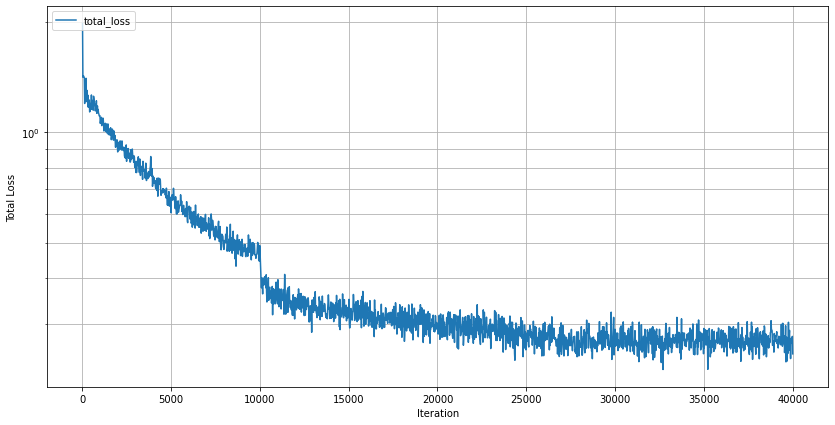

0.2934007807634771


In [8]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr('/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/New Baseline Models/MaskRCNN ResNet50 400ep LSJ _ DefaultLR _ 40000 _ [10000 25000 30000 35000]/metrics.json')
plt.grid(True, which="both")
plt.semilogy(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.legend(['total_loss'], loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
# plt.savefig('/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/Total_Loss_Curve.png')
plt.show()
print(experiment_metrics[1900]['total_loss'])

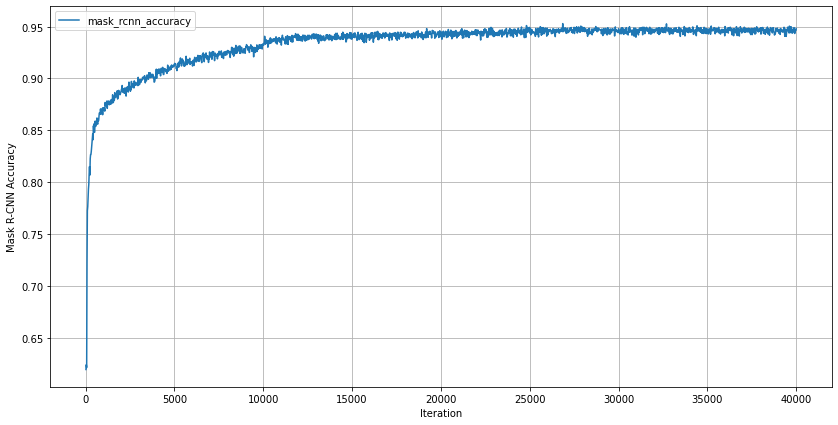

0.9478996975730425


In [8]:
experiment_metrics = load_json_arr('/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/New Baseline Models/MaskRCNN ResNet50 400ep LSJ _ DefaultLR _ 40000 _ [10000 25000 30000 35000]/metrics.json')

plt.grid(True, which="both")
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'mask_rcnn/accuracy' in x], 
    [x['mask_rcnn/accuracy'] for x in experiment_metrics if 'mask_rcnn/accuracy' in x])
plt.legend(['mask_rcnn_accuracy'], loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Mask R-CNN Accuracy')
# plt.savefig('/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/mask_rcnn_accuracy_Curve.png')
plt.show()
print(experiment_metrics[1895]['mask_rcnn/accuracy'])

# Testing and Inference

## Testing

In [8]:
cfg.train.init_checkpoint = '/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/New Baseline Models/MaskRCNN ResNet50 400ep LSJ _ DefaultLR _ 40000 _ [10000 25000 30000 35000]/model_final.pth'
model = instantiate(cfg.model)
model.to(cfg.train.device)
model = create_ddp_model(model)
DetectionCheckpointer(model).load(cfg.train.init_checkpoint)

# ret = inference_on_dataset(
#             model, instantiate(cfg.dataloader.test), instantiate(cfg.dataloader.evaluator)
#         )

model.eval()

[04/05 14:19:54 fvcore.common.checkpoint]: [Checkpointer] Loading from /home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/New Baseline Models/MaskRCNN ResNet50 400ep LSJ _ DefaultLR _ 40000 _ [10000 25000 30000 35000]/model_final.pth ...


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

## Inference for Visualization

In [9]:
from detectron2.data import detection_utils as utils
import copy
import torch
 # Show how to implement a minimal mapper, similar to the default DatasetMapper
def mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    dicts = []
    for i in range(len(dataset_dict)):
        image = utils.read_image(dataset_dict[i]["file_name"], format="BGR")
        temp = image.copy()
        utils.check_image_size(dataset_dict[i], temp)
        temp = np.moveaxis(temp, -1, 0)
        image = torch.from_numpy(temp)
        dicts.append({
           "image": image,
           'height': 720,
           'width': 1280,
        })
    return dicts

In [10]:
dataset_dict = detectron2.data.get_detection_dataset_dicts('CottonImaging_test')
data= mapper(dataset_dict)

outputs = []
for i in range(len(data)):
    with torch.no_grad():
     outputs = outputs + model([data[i]])


[04/05 14:04:36 d2.data.datasets.coco]: Loaded 61 images in COCO format from /home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/TestingSet2_imbalanced_30_Updated.json
[04/05 14:04:36 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[04/05 14:04:36 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  OpenBoll  | 397          | ClosedBoll | 427          |   Flower   | 244          |
|   Square   | 287          |            |              |            |              |
|   total    | 1355         |            |              |            |              |


/home/avl/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/avl/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# FiftyOne Visualization

In [21]:
dataset.delete()
dataset = fo.Dataset.from_dir(
    data_path="/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/test_images",
    labels_path='/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/TestingSet2_imbalanced_30_Updated.json',
    dataset_type=fo.types.COCODetectionDataset,
    label_types=["detections", "segmentations"],
    label_field = "ground_truth",
    #name="Model_2500_1024BatchSize_15LR"
)

#View summary info about the dataset
print(dataset)

 100% |███████████████████| 61/61 [1.9s elapsed, 0s remaining, 32.3 samples/s]         
Name:        2022.04.05.14.24.36
Media type:  image
Num samples: 61
Persistent:  False
Tags:        []
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth_detections:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Get class list
#classes = dataset.default_classes
classes = ["OpenBoll", "ClosedBoll", "Flower", "Square"]
# PATH = '/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/Base Model/Predictions/TestingSet Masks/'

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(dataset):
        i = 1
        # Load image
        image = cv2.imread(sample.filepath)
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w , c = image.shape
        temp = image.copy()
        temp = np.moveaxis(temp, -1, 0)
        image = torch.from_numpy(temp)
        dict_input = {
           "image": image,
           'height': 720,
           'width': 1280,
        }
        # Perform inference
        preds = model([dict_input])
        preds = preds[0]
        labels = preds["instances"].pred_classes.cpu().detach().numpy()
        scores = preds["instances"].scores.cpu().detach().numpy()
        #boxes = preds["instances"].pred_boxes.tensor.cpu().detach().numpy()
        masks = preds["instances"].pred_masks.cpu().detach().numpy()
        
        # Convert detections to FiftyOne format
        detections = []
        segmentations = []
#        for label, score, box, seg in zip(labels, scores, boxes, masks):
        for label, score, seg in zip(labels, scores, masks):
        
            # Generate images for each mask
#             cv2.imwrite(PATH+sample.filepath[sample.filepath.rfind('/')+1:-4]
#                         + f"_{i}_" + classes[label] + ".png", seg * 255)
            i += 1
            
            if score > 0.1:
                segmentations.append(
                    fo.Detection.from_mask(
                        mask=seg,
                        label=classes[label],
                        confidence=score
                        )
                    )

        # Save predictions to dataset
#         sample["predictions"] = fo.Detections(detections=detections)
        sample["predictions"] = fo.Detections(detections=segmentations)
        sample.save()

print("Finished adding predictions")

 100% |███████████████████| 61/61 [7.2s elapsed, 0s remaining, 8.4 samples/s]       
Finished adding predictions


In [20]:
score

0.058788292

In [27]:
session = fo.launch_app(dataset)

In [24]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth_segmentations",
    eval_key="eval",
    compute_mAP=True,
    use_masks=True,
    classes= classes,
)


Evaluating detections...
   0% ||------------------|  0/61 [12.0ms elapsed, ? remaining, ? samples/s] 

/home/avl/.local/lib/python3.8/site-packages/fiftyone/utils/eta.py:946: UserWarning: Ignoring unsupported attribute type '<class 'mongoengine.base.datastructures.BaseList'>'
  warnings.warn(msg)


 100% |███████████████████| 61/61 [6.3s elapsed, 0s remaining, 9.3 samples/s]       
Performing IoU sweep...
 100% |███████████████████| 61/61 [6.9s elapsed, 0s remaining, 7.9 samples/s]       



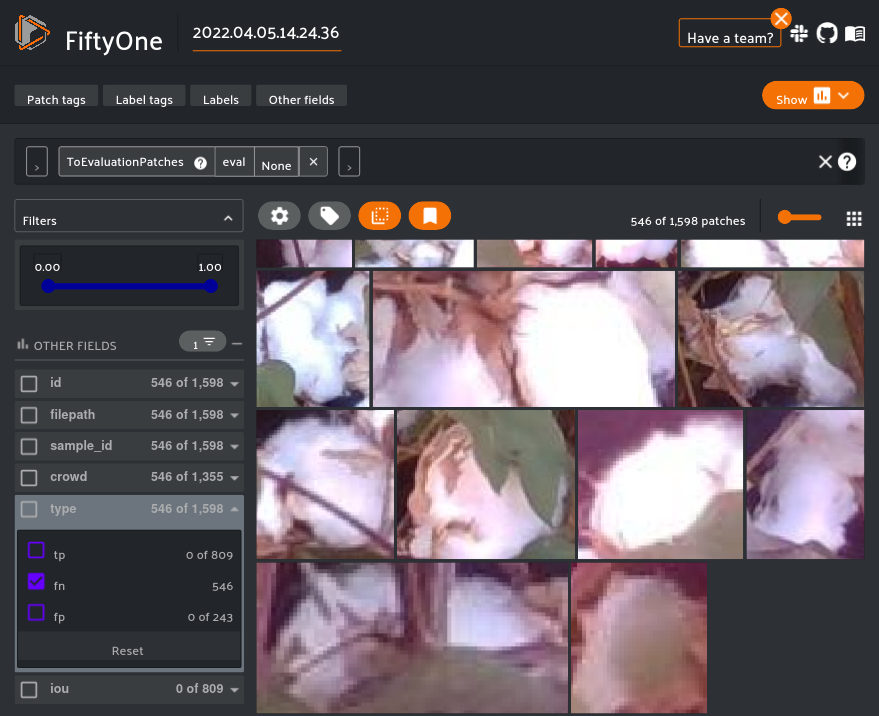

In [25]:
session = fo.launch_app(dataset)